In [ ]:
import numpy as np
from scipy.stats import rv_continuous
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd

In [2]:
# Reference for implementing a RV
# https://docs.scipy.org/doc/scipy/dev/contributor/adding_new.html#adding-a-new-statistics-distribution
# Similarly implemented RV: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gennorm.html#scipy.stats.gennorm

'''
Implementation with varying p

class special_exp(rv_continuous):
    def __init__(self, p, *args, **kwargs):
        self.p = p
        self.constant = 1 / (2*gamma(1+1/self.p))
        super().__init__(*args, **kwargs)
    
    def _pdf(self, x): #https://docs.scipy.org/doc/scipy/tutorial/stats/sampling.html
        return self.constant * np.exp(-np.abs(x)**self.p)
'''


class special_exp(rv_continuous): 
    def _pdf(self, x): #https://docs.scipy.org/doc/scipy/tutorial/stats/sampling.html
        return 1/2 * np.exp(-np.abs(x))
    
    def _cdf(self, x):
        if x >= 0:
            return 1/2 + 1/2 * (1-np.exp(-x))
        else:
            return 1/2 * np.exp(x)

    def _ppf(self, x):
        if x <= 1 and x >= 1/2:
            return -np.log(1-2*(x-1/2))
        else:
            return np.log(2*x)

def inv_cdf(x):
    if x >= 1/2:
        return -np.log(1-2*(x-1/2))
    else:
        return np.log(2*x)

# Generate g vector
def gen_g(n):
    g = []
    u = np.random.uniform(0,1,n)
    for u_i in u:
        g_i = inv_cdf(u_i)
        g.append(g_i)
    return g

# Generate Z
def gen_Z():
    return np.random.exponential(1, 1)

In [3]:
# Generate random point in the diamond
def gen_point_in_diamond(n, alpha):
    g = np.array(gen_g(n))
    z = gen_Z()[0]
    x = []
    for g_i in g:
        x_i = g_i / (np.sum(abs(g)) + z)
        x.append(x_i)

    # Normalize volume
    x = alpha * np.array(x) * (gamma(1+n))**(1/n)/2

    return x

In [4]:
# Generate random point in the cube
def gen_point_in_cube(dimension, bounds=[-1/2, 1/2]):
    x = []
    for i in range(dimension):
        x_i = np.random.uniform(bounds[0], bounds[1])
        x.append(x_i)
    return np.array(x)

In [5]:
def get_pairwise_distances(points):
    m = len(points)
    #n = len(points[0])
    pairwise_distances = np.zeros(shape=(m, m))
    i = 0
    for point1 in points:
        j = 0
        for point2 in points:
            if i < j:
                pairwise_distances[i][j] = np.linalg.norm(np.array(point1) - np.array(point2))
            j += 1
        i += 1
        
    return pairwise_distances

In [6]:
def check_for_contraction(pairwise_distances1, pairwise_distances2):
    upper_triangular = np.triu(np.ones_like(pairwise_distances1, dtype=bool),k=1)
    contraction = np.where(upper_triangular, pairwise_distances1 >= pairwise_distances2, True)
    if contraction.all():
        return True
    else:
        return False

In [7]:
def estimate_volume_of_intersection(centers, n, r, n0=1000000):
    all_points = np.concatenate(centers)
    all_points = np.abs(all_points)
    extreme_point = np.max(all_points)
    bounds = np.array([-(extreme_point+r), extreme_point+r])
    samples = np.random.uniform(bounds[0], bounds[1], (n0, n))

    intersection = sum(all(np.linalg.norm(sample - center) <= r for center in centers) for sample in samples)
    volume_box = (bounds[1] - bounds[0])**n
    print(f"intersection: {intersection}")
    volume = (intersection / n0) * volume_box
    
    return volume

In [14]:
def estimate_volume_of_intersection_grid(centers, n, r):
    n0 = 20**n
    num_step = int(np.ceil(n0**(1/n)))

    bounds = np.array([-(1+r), 1+r])
    steps = np.linspace(bounds[0], bounds[1], num_step)

    permutation = list(product(steps, repeat=n))
    grid = np.array(permutation)

    volume_box = (bounds[1] - bounds[0])**n

    intersection = sum(any(np.linalg.norm(sample - center) <= r for center in centers) for sample in grid)
    volume = (intersection / n0) * volume_box
    
    return (volume)**(1/n)

In [ ]:
def find_contraction(p, n, r, N, alpha):
    # Generate random points
    points_in_cube = []
    points_in_diamond = []
    for i in range(N):
        point_i = gen_point_in_cube(n)
        points_in_cube.append(point_i)
        point_j = gen_point_in_diamond(n, alpha)
        points_in_diamond.append(point_j)

    # Get pairwise distances and averages
    pairwise_distances_cube = get_pairwise_distances(points_in_cube)
    pairwise_distances_diamond = get_pairwise_distances(points_in_diamond)
    largest_avg_pairwise_distance = np.average(pairwise_distances_cube)
    smallest_avg_pairwise_distance = np.average(pairwise_distances_diamond)
    
    k = 1
    # Check for contraction
    if check_for_contraction(pairwise_distances_cube, pairwise_distances_diamond):
        cube_vol = estimate_volume_of_intersection_grid(points_in_cube, n, r)
        diamond_vol = estimate_volume_of_intersection_grid(points_in_diamond, n, r)
        return cube_vol, diamond_vol

    # Continue to generate new points while updated the largest and smallest pairwise distance averages
    while True:
        new_points_in_diamond = []
        new_points_in_cube = []
        for i in range(N):
            point_i = gen_point_in_cube(n)
            new_points_in_cube.append(point_i)
            point_j = gen_point_in_diamond(n, alpha)
            new_points_in_diamond.append(point_j)

        new_pairwise_distances_cube = get_pairwise_distances(new_points_in_cube)
        new_pairwise_distances_diamond = get_pairwise_distances(new_points_in_diamond)

        # Update largest
        cube_average = np.average(new_pairwise_distances_cube)
        if cube_average > largest_avg_pairwise_distance:
            points_in_cube = new_points_in_cube
            largest_avg_pairwise_distance = cube_average
            pairwise_distances_cube = new_pairwise_distances_cube

        # Update smallest
        diamond_average = np.average(new_pairwise_distances_diamond)
        if diamond_average < smallest_avg_pairwise_distance:
            points_in_diamond = new_points_in_diamond
            smallest_avg_pairwise_distance = diamond_average
            pairwise_distances_diamond = new_pairwise_distances_diamond
        
        
        k += 1
        
        # Check for contraction
        if check_for_contraction(pairwise_distances_cube, pairwise_distances_diamond):
            cube_vol = estimate_volume_of_intersection_grid(points_in_cube, n, r)
            diamond_vol = estimate_volume_of_intersection_grid(points_in_diamond, n, r)
            return cube_vol, diamond_vol

In [ ]:
def vary_r(n, r, N, alpha):
    df = pd.DataFrame(columns=['n', 'r', 'N', 'alpha', 'cube_vol', 'diamond_vol'])

    for radius in r:
        cube_vol, diamond_vol = find_contraction(1,n,radius,N,alpha)
        temp_df = pd.DataFrame({'n':[n],'r':[radius],'N':[N],'alpha':[alpha],'cube_vol':[cube_vol],'diamond_vol':[diamond_vol]})
        df = pd.concat([df, temp_df], ignore_index=True)
    
    return df

def vary_N(n, r, N, alpha):
    df = pd.DataFrame(columns=['n', 'r', 'N', 'alpha', 'cube_vol', 'diamond_vol'])

    for N0 in N:
        cube_vol, diamond_vol = find_contraction(1,n,r,N0,alpha)
        temp_df = pd.DataFrame({'n':[n],'r':[r],'N':[N0],'alpha':[alpha],'cube_vol':[cube_vol],'diamond_vol':[diamond_vol]})
        df = pd.concat([df, temp_df], ignore_index=True)

    return df

def vary_alpha(n, r, N, alpha):
    df = pd.DataFrame(columns=['n', 'r', 'N', 'alpha', 'cube_vol', 'diamond_vol'])

    for alph in alpha:
        cube_vol, diamond_vol = find_contraction(1,n,r,N,alpha)
        temp_df = pd.DataFrame({'n':[n],'r':[r],'N':[N],'alpha':[alph],'cube_vol':[cube_vol],'diamond_vol':[diamond_vol]})
        df = pd.concat([df, temp_df], ignore_index=True)

    return df


In [11]:
def graph_r(df):
    n = df['n'][0]
    N = df['N'][0]
    alpha = df['alpha'][0]

    plt.plot(df['r'], df['cube_vol'], label='cube_vol', color='blue', marker='s')
    plt.plot(df['r'], df['diamond_vol'], label='diamond_vol', color='red', marker='D')

    plt.title(f'Varying r (n={n}, N={N}, alpha={alpha})')
    plt.xlabel('r')
    plt.ylabel('Vol (Normalized)')
    plt.grid()
    
    plt.legend()

def graph_N(df):
    n = df['n'][0]
    r = df['r'][0]
    alpha = df['alpha'][0]

    plt.plot(df['N'], df['cube_vol'], label='cube_vol', color='blue', marker='s')
    plt.plot(df['N'], df['diamond_vol'], label='diamond_vol', color='red', marker='D')

    plt.title(f'Varying N (n={n}, r={r}, alpha={alpha})')
    plt.xlabel('N')
    plt.ylabel('Vol (Normalized)')
    plt.grid()

    plt.legend()

def graph_alpha(df):
    n = df['n'][0]
    r = df['r'][0]
    N = df['N'][0]

    plt.plot(df['alpha'], df['cube_vol'], label='cube_vol', color='blue', marker='s')
    plt.plot(df['alpha'], df['diamond_vol'], label='diamond_vol', color='red', marker='D')

    plt.title(f'Varying alpha (n={n}, r={r}, N={N})')
    plt.xlabel('alpha')
    plt.ylabel('Vol (Normalized)')
    plt.grid()
    
    plt.legend()

In [ ]:
n = 6
r = [n**(1/4), n**(1/3), n**(1/2), n]
N = 12
alpha = .7
r_df = vary_r(n, r, N, alpha)
r_graph = graph_r(r_df)
plt.show(r_graph)

8
points in the cube:
 [array([-0.42322617,  0.25665036, -0.10892627,  0.24440316, -0.47218804,
       -0.47714453]), array([-0.03896744,  0.35046365,  0.45000372,  0.30158563,  0.36101334,
       -0.16577175]), array([ 0.41386899, -0.23916952, -0.47476765, -0.44760757,  0.07945215,
       -0.1449627 ]), array([-0.11695213, -0.36008872,  0.37796705,  0.30613833,  0.28834315,
        0.44491116]), array([-0.00491981,  0.3398249 ,  0.24499545, -0.32514455, -0.01073088,
        0.09149981]), array([ 0.15169711, -0.28131819,  0.45909504, -0.35195133, -0.33158312,
        0.11473132]), array([ 0.33459771,  0.41185142, -0.20507921,  0.04391103,  0.28649963,
        0.49029818]), array([-0.47776916, -0.49495004,  0.13970542, -0.1682108 , -0.46497692,
        0.13222255])]
points in diamond:
 [array([-0.00411855,  0.12638565, -0.36840734,  0.00194415, -0.04527877,
        0.01597544]), array([-0.02245177,  0.58992757, -0.11193787,  0.04324407,  0.04362748,
       -0.04528094]), array([-0.13895

C:\Users\jacob\AppData\Local\Temp\ipykernel_22740\3232206110.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp_df], ignore_index=True)


points in the cube:
 [array([ 0.17764347,  0.19898604, -0.12819856, -0.45777016, -0.2346812 ,
        0.48537849]), array([ 0.31008376, -0.3352472 , -0.4110131 ,  0.39368186, -0.44185022,
        0.02626356]), array([ 0.47932169, -0.06407434, -0.49661076, -0.44888825,  0.49455594,
        0.41390055]), array([-0.44875465,  0.28311763, -0.44128486, -0.24728059,  0.30818263,
        0.38646105]), array([ 0.11742426,  0.4544858 ,  0.25818294,  0.43907659, -0.25310822,
       -0.47187791]), array([ 0.16651285, -0.40772736,  0.46624554,  0.1819126 ,  0.27602655,
       -0.11989401]), array([ 0.01367959,  0.023736  ,  0.31356439,  0.36783548,  0.35962357,
       -0.15333722]), array([-0.46434735, -0.47827213, -0.09290715, -0.21822458,  0.11736833,
       -0.11574967]), array([ 0.13324085,  0.45774573, -0.11009814, -0.45161754, -0.46311604,
       -0.23370868]), array([-0.49802168, -0.20080325,  0.09986038, -0.0772369 , -0.36373787,
        0.06455746])]
points in diamond:
 [array([ 0.2855475

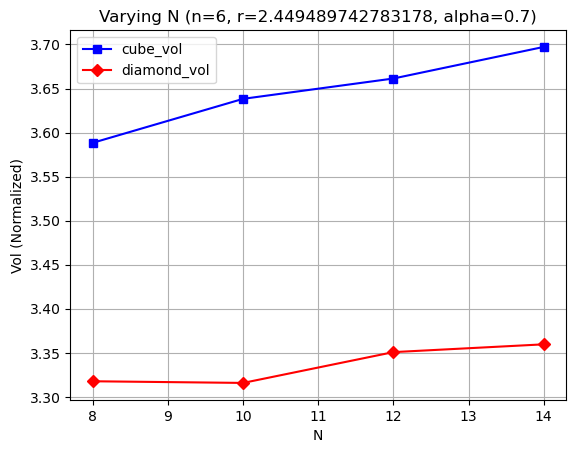

In [15]:
n = 6
r = n**(1/2)
N = [8,10,12,14]
alpha = .7

N_df = vary_N(n, r, N, alpha)
N_graph = graph_N(N_df)
plt.show(N_graph)

C:\Users\jacob\AppData\Local\Temp\ipykernel_18680\3616796992.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp_df], ignore_index=True)


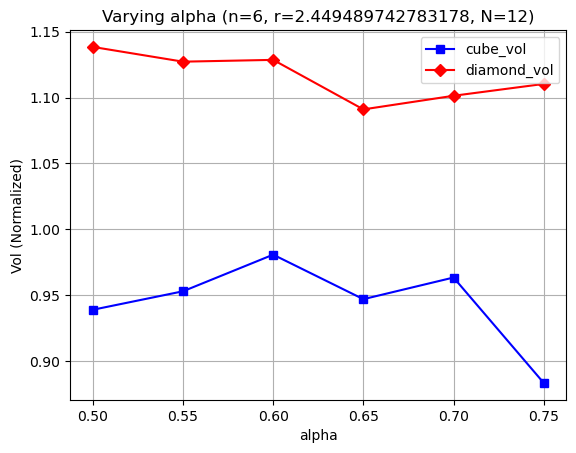

In [ ]:
n = 6
r = n**(1/2)
N = 2*n
alpha = [.5, .55, .6, .65, .7, .75]
alpha_df = vary_alpha(n, r, N, alpha)
alpha_graph = graph_alpha(alpha_df)
plt.show(alpha_graph)